In [ ]:
!pip install neo4j-graphrag neo4j openai

# 0. 연결 설정

### OpenAI 연결

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-..."

In [ ]:
from openai import OpenAI
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o",
    store=True,
    messages=[
        {"role": "user", "content": "write a haiku about ai"}
    ]
)
print(completion)

### neo4j 연결 설정

https://sandbox.neo4j.com/


- **Recommendations** 생성

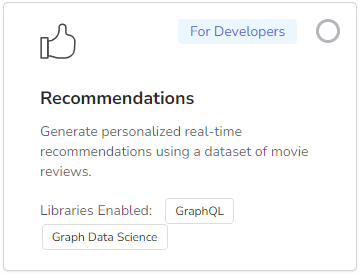

- 드라이버 정보 확인

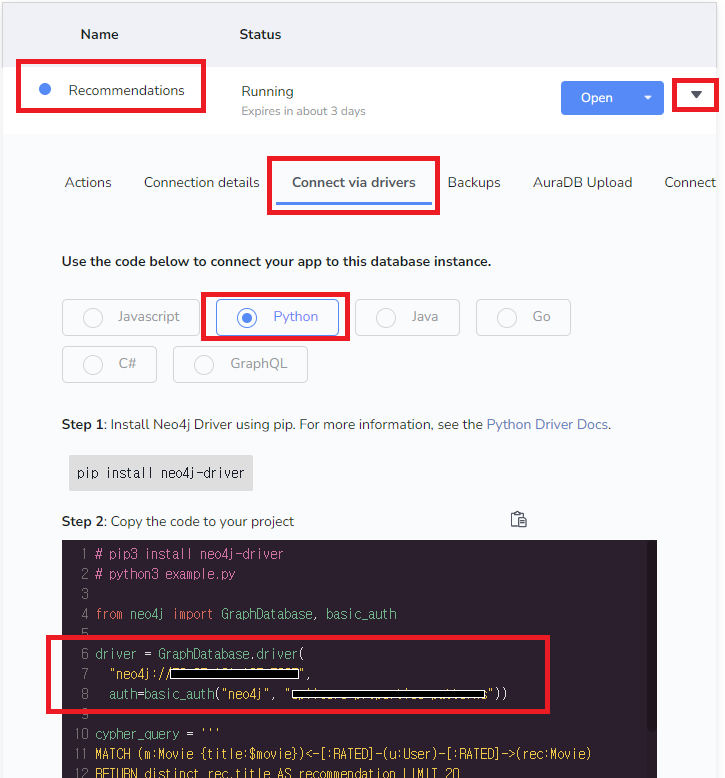

In [ ]:
from neo4j import GraphDatabase, basic_auth

driver = GraphDatabase.driver(
  "neo4j://0.0.0.0",
  auth=basic_auth("neo4j", "a-b-c"))

In [ ]:
cypher_query = '''
MATCH (m:Movie {title:$movie})<-[:RATED]-(u:User)-[:RATED]->(rec:Movie)
RETURN distinct rec.title AS recommendation LIMIT 20
'''

with driver.session(database="neo4j") as session:
  results = session.read_transaction(
    lambda tx: tx.run(cypher_query,
                      movie="Crimson Tide").data())
  for record in results:
    print(record['recommendation'])

# driver.close()

# 1. Vector RAG

## 임베딩 벡터 속성 생성

In [ ]:
def generate_embedding(text):
    embedding = client.embeddings.create(input = [text], model='text-embedding-ada-002').data[0].embedding
    return embedding

In [ ]:
def add_embedding_to_movie(tx):
    # 모든 Movie 노드의 plot을 임베딩하고, 그 값을 embedding 속성에 추가
    result = tx.run("MATCH (m:Movie) WHERE m.plot IS NOT NULL RETURN m.title AS title, m.plot AS plot, ID(m) AS id LIMIT 100")
    cnt = 0
    for record in result:
        title = record["title"]
        plot = record["plot"]
        node_id = record["id"]
        embedding = generate_embedding(plot)
        # 임베딩 벡터를 Neo4j에 저장
        tx.run("MATCH (m:Movie) WHERE ID(m) = $id SET m.plotEmbedding = $embedding", id=node_id, embedding=embedding)
        print(f"Updated movie '{title}' with embedding.")

with driver.session() as session:
    session.write_transaction(add_embedding_to_movie)

## 인덱스 생성과 벡터 검색

인덱스(VECTOR INDEX) 생성하기

- neo4j consol에 아래 쿼리 입력
```cypher
CREATE VECTOR INDEX moviePlotsEmbedding FOR (n:Movie) ON (n.plotEmbedding) OPTIONS {indexConfig: {
 `vector.dimensions`: 1536,
 `vector.similarity_function`: 'cosine'
}}
```

In [ ]:
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings
embedder = OpenAIEmbeddings(model="text-embedding-ada-002")
vector_retriever = VectorRetriever(
    driver,
    index_name="moviePlotsEmbedding",
    embedder=embedder,
    return_properties=["title", "plot"],
)

In [ ]:
query_text = "A cowboy doll is jealous when a new spaceman figure becomes the top toy." # 토이스토리 줄거리
retriever_result = vector_retriever.search(query_text=query_text, top_k=3)
print(retriever_result)

In [ ]:
retriever_result

In [ ]:
query_text = "A movie about a shooting incident."
retriever_result = vector_retriever.search(query_text=query_text, top_k=3)
print(retriever_result)

In [ ]:
retriever_result

In [ ]:
for k, item in enumerate(retriever_result.items):
    print(f"TOP {k+1}")
    print(item.content)
    print("score : ", item.metadata["score"])

## Vector Retriever 기반 답변 생성 (RAG)

In [ ]:
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

# Retrieval 후 답변을 생성할 때 사용할 LLM
llm = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})

In [ ]:
# RAG 파이프라인 초기설정
rag = GraphRAG(retriever=vector_retriever, llm=llm)

In [ ]:
# 질문하기
query_text = "What movies are sad romances?"
response = rag.search(query_text=query_text, retriever_config={"top_k": 5})
print(response.answer)

# 2. Cypher 활용한 Retriever 생성

### 2-1. 처리용 llm 선정

In [ ]:
from neo4j_graphrag.retrievers import Text2CypherRetriever

# 쿼리텍스트를 기반으로 Cypher 쿼리문을 생성하고, Retrieval 후 답변을 생성할 때 사용할 LLM
llm = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})

### 2-2. 스키마 추출

Neo4j DB Schema 예시

```
Node properties:
Person {name: STRING, born: INTEGER}
Movie {tagline: STRING, title: STRING, released: INTEGER}
Relationship properties:
ACTED_IN {roles: LIST}
REVIEWED {summary: STRING, rating: INTEGER}
The relationships:
(:Person)-[:ACTED_IN]->(:Movie)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:PRODUCED]->(:Movie)
(:Person)-[:WROTE]->(:Movie)
(:Person)-[:FOLLOWS]->(:Person)
(:Person)-[:REVIEWED]->(:Movie)
```

In [ ]:
from neo4j import GraphDatabase
from neo4j.time import Date

def get_node_datatype(value):
    """
        입력된 노드 Value의 데이터 타입을 반환하는 함수
    """
    if isinstance(value, str):
        return "STRING"
    elif isinstance(value, int):
        return "INTEGER"
    elif isinstance(value, float):
        return "FLOAT"
    elif isinstance(value, bool):
        return "BOOLEAN"
    elif isinstance(value, list):
        return f"LIST[{get_node_datatype(value[0])}]" if value else "LIST"
    elif isinstance(value, Date):
        return "DATE"
    else:
        return "UNKNOWN"

def get_schema(driver):
    """
        Graph DB의 정보를 받아 노드 및 관계의 프로퍼티를 추출하고 스키마 딕셔너리를 반환하는 함수
    """

    with driver.session() as session:
        # 노드 프로퍼티 및 타입 추출
        node_query = """
        MATCH (n)
        WITH DISTINCT labels(n) AS node_labels, keys(n) AS property_keys, n
        UNWIND node_labels AS label
        UNWIND property_keys AS key
        RETURN label, key, n[key] AS sample_value
        """
        nodes = session.run(node_query)

        # 관계 프로퍼티 및 타입 추출
        rel_query = """
        MATCH ()-[r]->()
        WITH DISTINCT type(r) AS rel_type, keys(r) AS property_keys, r
        UNWIND property_keys AS key
        RETURN rel_type, key, r[key] AS sample_value
        """
        relationships = session.run(rel_query)

        # 관계 유형 및 방향 추출
        rel_direction_query = """
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS start_label, type(r) AS rel_type, labels(b) AS end_label
        ORDER BY start_label, rel_type, end_label
        """
        rel_directions = session.run(rel_direction_query)

        # 스키마 딕셔너리 생성
        schema = {"nodes": {}, "relationships": {}, "relations": []}

        for record in nodes:
            label = record["label"]
            key = record["key"]
            sample_value = record["sample_value"] # 데이터 타입을 추론하기 위한 샘플 데이터
            inferred_type = get_node_datatype(sample_value)
            if label not in schema["nodes"]:
                schema["nodes"][label] = {}
            schema["nodes"][label][key] = inferred_type

        for record in relationships:
            rel_type = record["rel_type"]
            key = record["key"]
            sample_value = record["sample_value"] # 데이터 타입을 추론하기 위한 샘플 데이터
            inferred_type = get_node_datatype(sample_value)
            if rel_type not in schema["relationships"]:
                schema["relationships"][rel_type] = {}
            schema["relationships"][rel_type][key] = inferred_type

        for record in rel_directions:
            start_label = record["start_label"][0]
            rel_type = record["rel_type"]
            end_label = record["end_label"][0]
            schema["relations"].append(f"(:{start_label})-[:{rel_type}]->(:{end_label})")

        return schema

def format_schema(schema):
    """
        스키마 딕셔너리를 LLM에 제공하기 위해 원하는 형태로 formatting 하는 함수
    """
    result = []

    # 노드 프로퍼티 출력
    result.append("Node properties:")
    for label, properties in schema["nodes"].items():
        props = ", ".join(f"{k}: {v}" for k, v in properties.items())
        result.append(f"{label} {{{props}}}")

    # 관계 프로퍼티 출력
    result.append("Relationship properties:")
    for rel_type, properties in schema["relationships"].items():
        props = ", ".join(f"{k}: {v}" for k, v in properties.items())
        result.append(f"{rel_type} {{{props}}}")

    # 관계 프로퍼티 출력
    result.append("The relationships:")
    for relation in schema["relations"]:
        result.append(relation)

    return "\n".join(result)

In [ ]:
# Neo4j DB Schema 제공
schema = get_schema(driver)
neo4j_schema = format_schema(schema)
print(neo4j_schema)

### 2-3. 예시 작성

In [ ]:
# LLM INPUT / QUERY 예시 제공
examples = [
    "USER INPUT: 'Which actors starred in the Toy Story?' QUERY: MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) WHERE m.title = 'Toy Story' RETURN a.name",
    "USER INPUT: 'What is the average user rating for Toy Story?' QUERY: MATCH (u:User)-[r:RATED]->(m:Movie) WHERE m.title = 'Toy Story' RETURN AVG(r.rating)"
]

### 2-4. Retriever 선언

In [ ]:
# Text2CypherRetriever
graph_retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm,  # type: ignore
    neo4j_schema=neo4j_schema,
    examples=examples,
)

In [ ]:
# LLM을 통해 Cypher 쿼리를 생성하여 Neo4j DB에 보내고, 그 결과를 반환 => 이 결과는 RAG에 활용됨
query_text = "Which movies did Tom Hanks star in?"
search_result = graph_retriever.search(query_text=query_text)

In [ ]:
search_result.metadata['cypher']

In [ ]:
search_result.items

# 3. 그래프 RAG 구현

In [ ]:
# LLM 선정
llm_retriever = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})
llm_generation = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})

# 리트리버 설정
graph_retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm_retriever, # 리트리버가 사용할 LLM
    neo4j_schema=neo4j_schema,
    examples=examples,
)

rag = GraphRAG(retriever=graph_retriever, llm=llm_generation) # 답변 생성에 사용할 LLM

In [ ]:
# 질문하기
query_text = "Which movies did Tom Hanks star in?"

search_result = graph_retriever.search(query_text=query_text)
print("==== [Text2Cypher 를 통해 자동생성한 Cypher] ====")
print(search_result.metadata['cypher'])

response = rag.search(query_text=query_text)
print("\n==== [생성된 Cypher를 기반으로 최종답변생성] ====")
print(response.answer)

In [ ]:
# 질문하기
query_text = "Recommend 10 movies from the Comedy genre"
search_result = graph_retriever.search(query_text=query_text)
print("==== [Text2Cypher 를 통해 자동생성한 Cypher] ====")
print(search_result.metadata['cypher'])

response = rag.search(query_text=query_text)
print("\n==== [생성된 Cypher를 기반으로 최종답변생성] ====")
print(response.answer)

In [ ]:
# 질문하기
query_text = "Recommend only the top 5 movies with the most user reviews among Romance genre movies"
search_result = graph_retriever.search(query_text=query_text)
print("==== [Text2Cypher 를 통해 자동생성한 Cypher] ====")
print(search_result.metadata['cypher'])

response = rag.search(query_text=query_text)
print("\n==== [생성된 Cypher를 기반으로 최종답변생성] ====")
print(response.answer)

In [ ]:
# 질문하기
query_text = "your question"
search_result = graph_retriever.search(query_text=query_text)
print("==== [Text2Cypher 를 통해 자동생성한 Cypher] ====")
print(search_result.metadata['cypher'])

response = rag.search(query_text=query_text)
print("\n==== [생성된 Cypher를 기반으로 최종답변생성] ====")
print(response.answer)